# 04 - Early Fusion Multimodal Deepfake Detection

## Objective
Combine image, audio, and video features at the feature level (early fusion).

## Approach
1. Extract features from all modalities using pretrained models
2. Concatenate features before classification
3. Train unified classifier on combined features

## Architecture
```
Image → CNN → Features ─┐
Audio → Wav2Vec2 → Feat ├─→ Concat → Classifier → Prediction
Video → 3D ResNet → Feat ┘
```

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

# Image processing
from PIL import Image
import torchvision.transforms as transforms

# Audio processing
import librosa

# Model imports
import timm
from transformers import Wav2Vec2Model
import torchvision.models.video as video_models

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [19]:
class ConvNeXtDeepfakeDetector(nn.Module):
    """Image model - extracts features only"""
    def __init__(self, model_name='convnext_base', freeze_backbone=True):
        super().__init__()
        self.convnext = timm.create_model(model_name, pretrained=True, num_classes=0)
        
        if freeze_backbone:
            for param in self.convnext.parameters():
                param.requires_grad = False
        
        self.feature_dim = self.convnext.num_features
    
    def forward(self, x):
        features = self.convnext(x)
        return features

class Wav2Vec2Detector(nn.Module):
    """Audio model - extracts features only"""
    def __init__(self, model_name='facebook/wav2vec2-base', freeze_backbone=True):
        super().__init__()
        self.wav2vec2 = Wav2Vec2Model.from_pretrained(model_name)
        
        if freeze_backbone:
            for param in self.wav2vec2.parameters():
                param.requires_grad = False
        
        self.feature_dim = self.wav2vec2.config.hidden_size
        self.pool = nn.AdaptiveAvgPool1d(1)
    
    def forward(self, x):
        outputs = self.wav2vec2(x)
        hidden_states = outputs.last_hidden_state
        pooled = self.pool(hidden_states.transpose(1, 2)).squeeze(-1)
        return pooled

class ResNet3DDetector(nn.Module):
    """Video model - extracts features only"""
    def __init__(self, pretrained=True):
        super().__init__()
        self.resnet3d = video_models.r3d_18(weights='DEFAULT' if pretrained else None)
        # Remove final FC layer
        self.feature_extractor = nn.Sequential(*list(self.resnet3d.children())[:-1])
        self.feature_dim = 512
        
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
    
    def forward(self, x):
        # x shape: (batch, num_frames, C, H, W)
        # Reshape to: (batch, C, num_frames, H, W)
        x = x.permute(0, 2, 1, 3, 4)
        features = self.feature_extractor(x)
        features = features.squeeze(-1).squeeze(-1).squeeze(-1)
        return features

print('Base model classes defined!')

Base model classes defined!


In [20]:
# Dataset paths
TRAIN_FAKE_DIR_IMG = '../Deepfake image detection dataset/train-20250112T065955Z-001/train/fake'
TRAIN_REAL_DIR_IMG = '../Deepfake image detection dataset/train-20250112T065955Z-001/train/real'
TEST_FAKE_DIR_IMG = '../Deepfake image detection dataset/test-20250112T065939Z-001/test/fake'
TEST_REAL_DIR_IMG = '../Deepfake image detection dataset/test-20250112T065939Z-001/test/real'

REAL_AUDIO_DIR = '../DeepFake_AudioDataset/KAGGLE/AUDIO/REAL'
FAKE_AUDIO_DIR = '../DeepFake_AudioDataset/KAGGLE/AUDIO/FAKE'

TRAIN_FAKE_DIR_VID = '../dfd_faces/train/fake'
TRAIN_REAL_DIR_VID = '../dfd_faces/train/real'
TEST_FAKE_DIR_VID = '../dfd_faces/test/fake'
TEST_REAL_DIR_VID = '../dfd_faces/test/real'

# Parameters
IMG_SIZE = 224
NUM_FRAMES = 16
SAMPLE_RATE = 16000
MAX_AUDIO_LENGTH = SAMPLE_RATE * 10

BATCH_SIZE = 4  # Small due to memory constraints
EPOCHS = 15
LEARNING_RATE = 1e-4
NUM_WORKERS = 0

print("Configuration set!")

Configuration set!


In [21]:
class EarlyFusionDetector(nn.Module):
    def __init__(self, image_model, audio_model, video_model):
        super().__init__()
        self.image_encoder = image_model
        self.audio_encoder = audio_model
        self.video_encoder = video_model
        
        # Get feature dimensions
        img_dim = self.image_encoder.feature_dim  # 1024 for ConvNeXt base
        aud_dim = self.audio_encoder.feature_dim  # 768 for Wav2Vec2
        vid_dim = self.video_encoder.feature_dim  # 512 for ResNet3D
        
        total_dim = img_dim + aud_dim + vid_dim  # 2304
        
        # Fusion classifier (only these layers are trainable)
        self.fusion = nn.Sequential(
            nn.Linear(total_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 2)
        )
    
    def forward(self, image, audio, video):
        # Extract features from each modality (frozen encoders)
        img_feat = self.image_encoder(image)
        aud_feat = self.audio_encoder(audio)
        vid_feat = self.video_encoder(video)
        
        # Concatenate features (early fusion)
        combined = torch.cat([img_feat, aud_feat, vid_feat], dim=1)
        
        # Classify with trainable fusion layers
        output = self.fusion(combined)
        return output

print('Early Fusion Model Defined!')

Early Fusion Model Defined!


In [22]:
class MultimodalDeepfakeDataset(Dataset):
    """Dataset that returns image, audio, and video for the same sample"""
    def __init__(self, mode='train'):
        self.mode = mode
        
        if mode == 'train':
            self.img_fake_dir = TRAIN_FAKE_DIR_IMG
            self.img_real_dir = TRAIN_REAL_DIR_IMG
            self.vid_fake_dir = TRAIN_FAKE_DIR_VID
            self.vid_real_dir = TRAIN_REAL_DIR_VID
        else:
            self.img_fake_dir = TEST_FAKE_DIR_IMG
            self.img_real_dir = TEST_REAL_DIR_IMG
            self.vid_fake_dir = TEST_FAKE_DIR_VID
            self.vid_real_dir = TEST_REAL_DIR_VID
        
        # Load image paths
        self.image_paths = []
        self.labels = []
        
        if os.path.exists(self.img_fake_dir):
            fake_imgs = [os.path.join(self.img_fake_dir, f) for f in os.listdir(self.img_fake_dir) 
                        if f.endswith(('.jpg', '.png'))]
            self.image_paths.extend(fake_imgs[:100])  # Limit for demo
            self.labels.extend([1] * len(fake_imgs[:100]))
        
        if os.path.exists(self.img_real_dir):
            real_imgs = [os.path.join(self.img_real_dir, f) for f in os.listdir(self.img_real_dir) 
                        if f.endswith(('.jpg', '.png'))]
            self.image_paths.extend(real_imgs[:100])
            self.labels.extend([0] * len(real_imgs[:100]))
        
        # Load audio paths
        self.audio_paths = []
        if os.path.exists(FAKE_AUDIO_DIR):
            fake_aud = [os.path.join(FAKE_AUDIO_DIR, f) for f in os.listdir(FAKE_AUDIO_DIR) 
                       if f.endswith(('.wav', '.mp3'))][:50]
            self.audio_paths.extend(fake_aud)
        
        if os.path.exists(REAL_AUDIO_DIR):
            real_aud = [os.path.join(REAL_AUDIO_DIR, f) for f in os.listdir(REAL_AUDIO_DIR) 
                       if f.endswith(('.wav', '.mp3'))][:50]
            self.audio_paths.extend(real_aud)
        
        # Load video folders
        self.video_folders = []
        if os.path.exists(self.vid_fake_dir):
            fake_vids = [os.path.join(self.vid_fake_dir, f) for f in os.listdir(self.vid_fake_dir) 
                        if os.path.isdir(os.path.join(self.vid_fake_dir, f))][:50]
            self.video_folders.extend(fake_vids)
        
        if os.path.exists(self.vid_real_dir):
            real_vids = [os.path.join(self.vid_real_dir, f) for f in os.listdir(self.vid_real_dir) 
                        if os.path.isdir(os.path.join(self.vid_real_dir, f))][:50]
            self.video_folders.extend(real_vids)
        
        # Image transforms
        self.img_transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        print(f"{mode.upper()}: {len(self.image_paths)} samples")
    
    def __len__(self):
        return min(len(self.image_paths), len(self.audio_paths), len(self.video_folders))
    
    def load_image(self, idx):
        img_path = self.image_paths[idx % len(self.image_paths)]
        try:
            img = Image.open(img_path).convert('RGB')
            return self.img_transform(img)
        except:
            return torch.zeros(3, IMG_SIZE, IMG_SIZE)
    
    def load_audio(self, idx):
        aud_path = self.audio_paths[idx % len(self.audio_paths)]
        try:
            audio, _ = librosa.load(aud_path, sr=SAMPLE_RATE, duration=10)
            if len(audio) < MAX_AUDIO_LENGTH:
                audio = np.pad(audio, (0, MAX_AUDIO_LENGTH - len(audio)))
            else:
                audio = audio[:MAX_AUDIO_LENGTH]
            return torch.FloatTensor(audio)
        except:
            return torch.zeros(MAX_AUDIO_LENGTH)
    
    def load_video(self, idx):
        vid_folder = self.video_folders[idx % len(self.video_folders)]
        try:
            frames_files = sorted([f for f in os.listdir(vid_folder) if f.endswith(('.jpg', '.png'))])
            indices = np.linspace(0, len(frames_files)-1, NUM_FRAMES, dtype=int)
            
            frames = []
            for i in indices:
                img = Image.open(os.path.join(vid_folder, frames_files[i])).convert('RGB')
                frames.append(self.img_transform(img))
            
            return torch.stack(frames)
        except:
            return torch.zeros(NUM_FRAMES, 3, IMG_SIZE, IMG_SIZE)
    
    def __getitem__(self, idx):
        image = self.load_image(idx)
        audio = self.load_audio(idx)
        video = self.load_video(idx)
        label = self.labels[idx % len(self.labels)]
        
        return image, audio, video, label

print('Multimodal Dataset defined!')

Multimodal Dataset defined!


In [23]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    pbar = tqdm(loader, desc='Training')
    for image, audio, video, labels in pbar:
        image = image.to(device)
        audio = audio.to(device)
        video = video.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(image, audio, video)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{running_loss/len(pbar):.4f}', 
                         'acc': f'{100.*correct/total:.2f}%'})
    
    return running_loss / len(loader), 100. * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels, all_probs = [], [], []
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Evaluating')
        for image, audio, video, labels in pbar:
            image = image.to(device)
            audio = audio.to(device)
            video = video.to(device)
            labels = labels.to(device)
            
            outputs = model(image, audio, video)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    return running_loss / len(loader), all_preds, all_labels, all_probs

def calculate_metrics(y_true, y_pred, y_probs):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_probs) if len(np.unique(y_true)) > 1 else 0.0
    }

print('Training functions defined!')

Training functions defined!


In [24]:
print("Loading pretrained models...")
print("=" * 60)

# Load image model
image_model = ConvNeXtDeepfakeDetector(freeze_backbone=True)
if os.path.exists('best_image_model_convnext.pth'):
    print("✓ Loading saved ConvNeXt weights from 'best_image_model_convnext.pth'")
    try:
        state_dict = torch.load('best_image_model_convnext.pth', map_location=device)
        # Try loading the full state dict first
        try:
            image_model.load_state_dict(state_dict, strict=False)
        except:
            # If that fails, filter only convnext weights
            encoder_dict = {k.replace('convnext.', ''): v for k, v in state_dict.items() if 'convnext' in k}
            if encoder_dict:
                image_model.convnext.load_state_dict(encoder_dict, strict=False)
        print("  ConvNeXt loaded successfully!")
    except Exception as e:
        print(f"  Warning: Could not load weights ({e}), using pretrained ConvNeXt from timm")
else:
    print("✗ No saved ConvNeXt found, using pretrained from timm")

# Load audio model
audio_model = Wav2Vec2Detector(freeze_backbone=True)
if os.path.exists('best_audio_model_wav2vec2.pth'):
    print("✓ Loading saved Wav2Vec2 weights from 'best_audio_model_wav2vec2.pth'")
    try:
        state_dict = torch.load('best_audio_model_wav2vec2.pth', map_location=device)
        try:
            audio_model.load_state_dict(state_dict, strict=False)
        except:
            encoder_dict = {k.replace('wav2vec2.', ''): v for k, v in state_dict.items() if 'wav2vec2' in k}
            if encoder_dict:
                audio_model.wav2vec2.load_state_dict(encoder_dict, strict=False)
        print("  Wav2Vec2 loaded successfully!")
    except Exception as e:
        print(f"  Warning: Could not load weights ({e}), using pretrained Wav2Vec2 from HuggingFace")
else:
    print("✗ No saved Wav2Vec2 found, using pretrained from HuggingFace")

# Load video model
video_model = ResNet3DDetector(pretrained=True)
if os.path.exists('best_video_model_resnet3d.pth'):
    print("✓ Loading saved 3D ResNet weights from 'best_video_model_resnet3d.pth'")
    try:
        state_dict = torch.load('best_video_model_resnet3d.pth', map_location=device)
        video_model.load_state_dict(state_dict, strict=False)
        print("  3D ResNet loaded successfully!")
    except Exception as e:
        print(f"  Warning: Could not load weights ({e}), using pretrained 3D ResNet from torchvision")
else:
    print("✗ No saved 3D ResNet found, using pretrained from torchvision")

print("=" * 60)

# Create early fusion model
model = EarlyFusionDetector(image_model, audio_model, video_model)
model = model.to(device)

print("\nModel Architecture Summary:")
print("-" * 60)
print(f"Image Encoder (ConvNeXt): {image_model.feature_dim} features → FROZEN")
print(f"Audio Encoder (Wav2Vec2): {audio_model.feature_dim} features → FROZEN")
print(f"Video Encoder (3D ResNet): {video_model.feature_dim} features → FROZEN")
print(f"Total concatenated features: {image_model.feature_dim + audio_model.feature_dim + video_model.feature_dim}")
print("-" * 60)
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters (fusion only): {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print("=" * 60)

Loading pretrained models...
✓ Loading saved ConvNeXt weights from 'best_image_model_convnext.pth'
  ConvNeXt loaded successfully!
✓ Loading saved Wav2Vec2 weights from 'best_audio_model_wav2vec2.pth'
  Wav2Vec2 loaded successfully!
✓ Loading saved 3D ResNet weights from 'best_video_model_resnet3d.pth'
  3D ResNet loaded successfully!

Model Architecture Summary:
------------------------------------------------------------
Image Encoder (ConvNeXt): 1024 features → FROZEN
Audio Encoder (Wav2Vec2): 768 features → FROZEN
Video Encoder (3D ResNet): 512 features → FROZEN
Total concatenated features: 2304
------------------------------------------------------------
Total parameters: 218,329,682
Trainable parameters (fusion only): 3,225,234


In [25]:
train_dataset = MultimodalDeepfakeDataset(mode='train')
test_dataset = MultimodalDeepfakeDataset(mode='test')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

TRAIN: 200 samples
TEST: 200 samples
Train batches: 15
Test batches: 15


## Training and Evaluation

Load the best models from previous notebooks and combine them.
Train only the fusion layers while keeping encoders frozen.

In [26]:
print(f"\n{'='*60}")
print("Training Early Fusion Multimodal Detector")
print(f"{'='*60}\n")

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_acc = 0.0
best_state = None

import time
start_time = time.time()

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 60)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate
    val_loss, val_preds, val_labels, val_probs = evaluate(model, test_loader, criterion, device)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_state = model.state_dict().copy()
        print(f"✓ New best accuracy: {best_acc:.2f}%")
    
    scheduler.step()

training_time = time.time() - start_time

# Load best model
model.load_state_dict(best_state)

# Final evaluation
print(f"\nFinal evaluation on best model...")
_, final_preds, final_labels, final_probs = evaluate(model, test_loader, criterion, device)

metrics = calculate_metrics(final_labels, final_preds, final_probs)
metrics['training_time'] = training_time
metrics['best_val_acc'] = best_acc

print(f"\nEarly Fusion Final Results:")
print("-" * 60)
for key, value in metrics.items():
    if key == 'training_time':
        print(f"{key}: {value:.2f}s ({value/60:.2f} min)")
    else:
        print(f"{key}: {value:.4f}")


Training Early Fusion Multimodal Detector


Epoch 1/15
------------------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.38it/s]


Train Loss: 0.7664, Train Acc: 31.03%
Val Loss: 0.6747, Val Acc: 70.69%
✓ New best accuracy: 70.69%

Epoch 2/15
------------------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.44it/s]


Train Loss: 0.6892, Train Acc: 58.62%
Val Loss: 0.6402, Val Acc: 79.31%
✓ New best accuracy: 79.31%

Epoch 3/15
------------------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.45it/s]


Train Loss: 0.6279, Train Acc: 68.97%
Val Loss: 0.5778, Val Acc: 91.38%
✓ New best accuracy: 91.38%

Epoch 4/15
------------------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.44it/s]


Train Loss: 0.5366, Train Acc: 87.93%
Val Loss: 0.5784, Val Acc: 89.66%

Epoch 5/15
------------------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.38it/s]


Train Loss: 0.5062, Train Acc: 91.38%
Val Loss: 0.5234, Val Acc: 98.28%
✓ New best accuracy: 98.28%

Epoch 6/15
------------------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.46it/s]


Train Loss: 0.4507, Train Acc: 98.28%
Val Loss: 0.4729, Val Acc: 98.28%

Epoch 7/15
------------------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.42it/s]


Train Loss: 0.4061, Train Acc: 100.00%
Val Loss: 0.4236, Val Acc: 100.00%
✓ New best accuracy: 100.00%

Epoch 8/15
------------------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.46it/s]


Train Loss: 0.3837, Train Acc: 100.00%
Val Loss: 0.3974, Val Acc: 100.00%

Epoch 9/15
------------------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.52it/s]


Train Loss: 0.3586, Train Acc: 100.00%
Val Loss: 0.3656, Val Acc: 100.00%

Epoch 10/15
------------------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.45it/s]


Train Loss: 0.3457, Train Acc: 100.00%
Val Loss: 0.3452, Val Acc: 100.00%

Epoch 11/15
------------------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.44it/s]


Train Loss: 0.3623, Train Acc: 100.00%
Val Loss: 0.3425, Val Acc: 100.00%

Epoch 12/15
------------------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.38it/s]


Train Loss: 0.3498, Train Acc: 100.00%
Val Loss: 0.3114, Val Acc: 100.00%

Epoch 13/15
------------------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.35it/s]


Train Loss: 0.3426, Train Acc: 100.00%
Val Loss: 0.3567, Val Acc: 100.00%

Epoch 14/15
------------------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.38it/s]


Train Loss: 0.3356, Train Acc: 100.00%
Val Loss: 0.3375, Val Acc: 100.00%

Epoch 15/15
------------------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.45it/s]


Train Loss: 0.3139, Train Acc: 100.00%
Val Loss: 0.3141, Val Acc: 100.00%

Final evaluation on best model...


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.45it/s]


Early Fusion Final Results:
------------------------------------------------------------
accuracy: 1.0000
precision: 1.0000
recall: 1.0000
f1: 1.0000
roc_auc: 0.0000
training_time: 214.10s (3.57 min)
best_val_acc: 100.0000


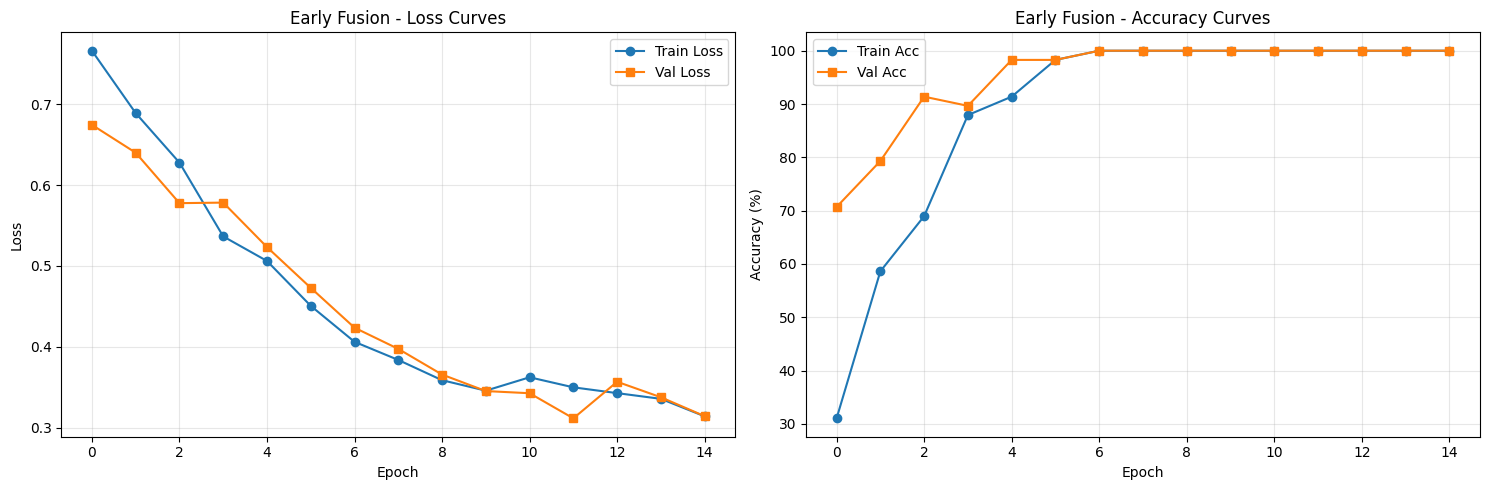

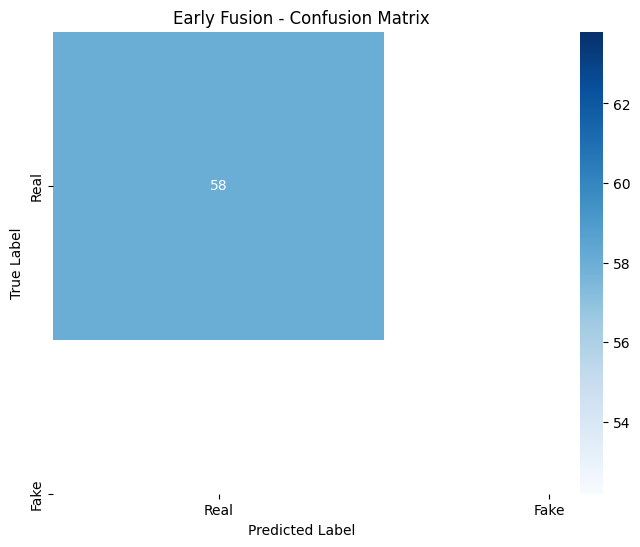

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Early Fusion - Loss Curves')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy curves
axes[1].plot(train_accs, label='Train Acc', marker='o')
axes[1].plot(val_accs, label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Early Fusion - Accuracy Curves')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(final_labels, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.title('Early Fusion - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
if len(np.unique(final_labels)) > 1:
    fpr, tpr, _ = roc_curve(final_labels, final_probs)
    roc_auc = roc_auc_score(final_labels, final_probs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Early Fusion - ROC Curve')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

In [28]:
# Save the trained model
torch.save(model.state_dict(), 'early_fusion_model.pth')
print("✓ Model saved as 'early_fusion_model.pth'")

# Save results
results_df = pd.DataFrame([metrics])
results_df.to_csv('early_fusion_results.csv', index=False)
print("✓ Results saved as 'early_fusion_results.csv'")

# Summary
print(f"\n{'='*60}")
print("EARLY FUSION SUMMARY")
print(f"{'='*60}")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1-Score: {metrics['f1']:.4f}")
print(f"ROC-AUC: {metrics['roc_auc']:.4f}")
print(f"Training Time: {metrics['training_time']:.2f}s")
print(f"{'='*60}")

✓ Model saved as 'early_fusion_model.pth'
✓ Results saved as 'early_fusion_results.csv'

EARLY FUSION SUMMARY
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AUC: 0.0000
Training Time: 214.10s
